![](/images/blog/dota-hero-embedding.png)

One of the coolest results in natural language processing is the success of word embedding models like [Word2vec](https://en.wikipedia.org/wiki/Word2vec). These models are able to extract rich semantic information from words using surprisingly simple models like [CBOW](https://en.wikipedia.org/wiki/Bag-of-words_model#CBOW) or [skip-gram](https://en.wikipedia.org/wiki/N-gram#Skip-gram). What if we could use these generic modelling strategies to learn embeddings for something completely different - say, Dota 2 heroes.

In this post, we'll use the [OpenDota API](https://docs.opendota.com/) to collect data from professional Dota 2 matches and use [Keras](https://keras.io/) to train a Word2vec-like model for hero embeddings.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gilgi/gilgi.github.com/blob/src/posts/dota_hero_embedding.ipynb)

<!-- TEASER_END -->

In [0]:
import requests
import urllib
import pandas as pd
import numpy as np

In [0]:
N_NEG = 5
N_HIDDEN = 10
BATCH_SIZE = 32

One hypothesis we might have about a good hero embedding is that it should be able to learn what heroes typically fulfill which roles on a team. This makes sense from a Word2vec perspective because if our goal is to predict the last hero a team will pick, one thing that will help is to consider how many carries or supports the team has already picked. For example, if a team already has a lot of carries, they will almost certainly pick a support next.

In order to test this, we will set up a function to color-code heroes according to their role (as annotated in the OpenDota API). We will color supports in blue, carries in red, and heroes that are annotated as both in purple. Heroes that have neither annotation will be gray.

In [0]:
def color(roles):
    if 'Support' in roles and 'Carry' in roles:
        return 'purple'
    elif 'Support' in roles:
        return 'blue'
    elif 'Carry' in roles:
        return 'red'
    else:
        return 'gray'

To actually get the hero information, we will use the OpenDota API. We can then apply our color function to the table of heroes.

In [0]:
heroes_df = pd.read_json('https://api.opendota.com/api/heroes')
heroes_df['sid'] = heroes_df.index
heroes_df['color'] = heroes_df.roles.map(color)
N_HEROES = len(heroes_df)
heroes_df.head()

,attack_type,id,legs,localized_name,name,primary_attr,roles,sid,color
0,Melee,1,2,Anti-Mage,npc_dota_hero_antimage,agi,"[Carry, Escape, Nuker]",0,red
1,Melee,2,2,Axe,npc_dota_hero_axe,str,"[Initiator, Durable, Disabler, Jungler]",1,gray
2,Ranged,3,4,Bane,npc_dota_hero_bane,int,"[Support, Disabler, Nuker, Durable]",2,blue
3,Melee,4,2,Bloodseeker,npc_dota_hero_bloodseeker,agi,"[Carry, Disabler, Jungler, Nuker, Initiator]",3,red
4,Ranged,5,2,Crystal Maiden,npc_dota_hero_crystal_maiden,int,"[Support, Disabler, Nuker, Jungler]",4,blue


To check that this is working as expected, we can filter the table to include only support heroes:

In [0]:
heroes_df[heroes_df.roles.map(lambda x: 'Support' in x)].head()

,attack_type,id,legs,localized_name,name,primary_attr,roles,sid,color
2,Ranged,3,4,Bane,npc_dota_hero_bane,int,"[Support, Disabler, Nuker, Durable]",2,blue
4,Ranged,5,2,Crystal Maiden,npc_dota_hero_crystal_maiden,int,"[Support, Disabler, Nuker, Jungler]",4,blue
6,Melee,7,2,Earthshaker,npc_dota_hero_earthshaker,str,"[Support, Initiator, Disabler, Nuker]",6,blue
8,Ranged,9,2,Mirana,npc_dota_hero_mirana,agi,"[Carry, Support, Escape, Nuker, Disabler]",8,purple
15,Melee,16,6,Sand King,npc_dota_hero_sand_king,str,"[Initiator, Disabler, Support, Nuker, Escape, ...",15,blue


Next, we will need some matches to train on. We will again use the OpenDota API to get pick and ban information for recent professional Dota 2 matches. The first API endpoint we will hit looks like this:

In [0]:
matches_df = pd.read_json('https://api.opendota.com/api/proMatches')
matches_df.head()

,dire_name,dire_score,dire_team_id,duration,league_name,leagueid,match_id,radiant_name,radiant_score,radiant_team_id,radiant_win,series_id,series_type,start_time
0,Gorillaz-Pride,27,5055770.0,2141,MLeS,3688,3918178688,Infamous,35,5065748,True,222482,1,2018-05-27 20:45:29
1,Gorillaz-Pride,13,5055770.0,1759,MLeS,3688,3918108668,Infamous,34,5065748,True,222482,1,2018-05-27 19:39:06
2,Wrong5,11,3324727.0,1613,CZ-SK Dota 2 League Season 10,5481,3918066799,LIDOVEJ GAMING,28,5044245,True,0,0,2018-05-27 19:09:42
3,Vzpoura Goliardu,29,5326172.0,2360,CZ-SK Dota 2 League Season 10,5481,3917982657,Fatal Error,52,5260723,True,0,0,2018-05-27 18:06:52
4,Wrong5,28,3324727.0,2468,CZ-SK Dota 2 League Season 10,5481,3917897770,Muzikanti,37,5348456,True,0,0,2018-05-27 17:03:22


That table doesn't include any information about the picks or bans for each match, but it does include a `match_id` which we can use to hit another endpoint:

In [0]:
match_df = pd.DataFrame(requests.get('https://api.opendota.com/api/matches/3914148169').json()['picks_bans'])
match_df = match_df.merge(heroes_df, left_on='hero_id', right_on='id')
print match_df[(match_df['team'] == 0) & match_df['is_pick'] == True]
print match_df[(match_df['team'] == 0) & match_df['is_pick'] == True]['sid'].as_matrix()
print [heroes_df.loc[i, 'localized_name'] for i in match_df[(match_df['team'] == 0) & match_df['is_pick'] == True]['sid'].as_matrix()]

    hero_id  is_pick    match_id  ord  order  team attack_type   id  legs  \
7        72     True  3914148169    7      7     0      Ranged   72     2   
8        87     True  3914148169    8      8     0      Ranged   87     2   
14      103     True  3914148169   14     14     0       Melee  103     2   
16       49     True  3914148169   16     16     0       Melee   49     2   
21       15     True  3914148169   21     21     0      Ranged   15     0   

   localized_name                         name primary_attr  \
7      Gyrocopter     npc_dota_hero_gyrocopter          agi   
8       Disruptor      npc_dota_hero_disruptor          int   
14    Elder Titan    npc_dota_hero_elder_titan          str   
16  Dragon Knight  npc_dota_hero_dragon_knight          str   
21          Razor          npc_dota_hero_razor          agi   

                                                roles  sid color  
7                            [Carry, Nuker, Disabler]   70   red  
8               [Support

Using this it looks like it should be possible to loop over many `match_id`s from the table of recent pro matches, then extract the hero ID's (`sid`) from each individual match result. This is a bit annoying, because to train our model we will want a lot of data, and if we get it this way we will be making a separate call to the OpenDota API for each match we want to add to our dataset. Is there a better way?

One alternative is to use the OpenDota Explorer API, which allows us to write SQL-style queries to retrieve exactly the data we want. In this case, we can request the `picks_bans` column of the `matches` table for matches played on specific patches (in this case 7.13 and 7.14).

In [0]:
query_string = "SELECT matches.picks_bans FROM matches JOIN match_patch using(match_id) WHERE match_patch.patch = '7.14' OR match_patch.patch = '7.13'"
quoted_string = urllib.quote(query_string)
json_response = requests.get(
    'https://api.opendota.com/api/explorer?sql=' + quoted_string).json()

As a test, we can manually parse out the first row of the results returned by our SQL query and show that we can successfully get the 5 hero IDs (`sid`) for the heroes picked by one of the teams in one match:

In [0]:
match_df = pd.DataFrame(json_response['rows'][0]['picks_bans'])
match_df = match_df.merge(heroes_df, left_on='hero_id', right_on='id')
match_df[(match_df['team'] == 0) & (match_df['is_pick'] == True)]['sid'].as_matrix()

array([ 70,  28,  58, 100,  16])

Now that this seems to be working, we can parse the entire set of results into a pair of `numpy` arrays (one containing the picks and one containing the bans), extracting this information for both teams involved in each match.

In [0]:
picks_list = []
bans_list = []
for i in range(json_response['rowCount']):
    match_df = pd.DataFrame(json_response['rows'][i]['picks_bans'])
    if 'team' not in match_df.columns:
        continue
    match_df = match_df.merge(heroes_df, left_on='hero_id', right_on='id')
    if len(match_df[(match_df['team'] == 0) & (match_df['is_pick'] == False)]['sid'].as_matrix()[:5]) < 5 or len(match_df[(match_df['team'] == 1) & (match_df['is_pick'] == False)]['sid'].as_matrix()[:5]) < 5:
        continue
    for j in [0, 1]:
        picks_list.append(match_df[(match_df['team'] == j) & (match_df['is_pick'] == True)]['sid'].as_matrix())
        bans_list.append(match_df[(match_df['team'] == int(not j)) & (match_df['is_pick'] == False)]['sid'].as_matrix()[:5])
picks_array = np.array(picks_list)
bans_array = np.array(bans_list)
print picks_array.shape, bans_array.shape

(1582, 5) (1582, 5)


Before we dig into wiring this dataset into Keras, we should first take a break to explain Word2vec and its variants at a high level.

At the top level, Word2vec has two major variant models: CBOW and skip-gram, which are illustrated below:

![](https://i.stack.imgur.com/O2YeO.png)

In the notation of this image, we are looking at an ordered sequence of words $w(t-2), w(t-1), w(t), w(t+1), w(t+2)$, where $w(i)$ represents a word at a particular index $i$. We can think of  $w(t)$ the target word and $w(t-2), w(t-1), w(t+1), w(t+2)$ as the context surrounding the target word.

We can look at each model as a slightly different prediction problem. CBOW takes the context words as input and tries to predict the target word. Skip-gram, on the other hand, takes the middle word $w(t)$ as input and tries to predict the surrounding context words.

From the perspective of modeling probability distributions, CBOW models 

$$p(w(t) \mid w(t-2), w(t-1), w(t+1), w(t+2))$$

while skip-gram tries to maximize

$$\sum_{j \in \{-2, -1, 1, 2\}} \log p(w(t+j) \mid w(t))$$

For this example, we will choose CBOW, which is thought to perform slightly better when the training dataset is small and performance on rare words isn't super important.

We can go one level deeper into the CBOW model to see how it works:

![](https://i.stack.imgur.com/FWO7L.png)

In the notation of this image, the $x$s are the context words, $V$ is the total number of words in the vocabulary, and $N$ is the number of dimensions we wish to use for our embedding. The context words $x$ are represented as one-hot vectors and are converted to dense vector representations by multiplying them by a weight matrix $W$, so that $h=Wx$. Since $W$ is multiplying one hot vectors $x$, we can call it an embedding matrix - the $i$th row of $W$ is the dense vector representation of the $i$th word in the vocabulary.

Note that there are $C$ context words $x_1, x_2, \ldots, x_C$. Each one has a distinct dense representation - for example $h_1=Wx_1$. Under the CBOW model, we combine all the dense representations into a single vector of length $N$ by addition or averaging (for a constant context size $C$ these are equivalent up to a scaling constant which should get absorbed into $W'$ during training). This means we can write the combined representation of the context as $h=\sum_j W x_j$ where $j$ iterates over the context words.

The overall goal of the CBOW model is to use this representation $h$ to predict the target word. This can be seen as a multi-class classification problem. The simplest way to classify the representation $h$ into one of the possible classes (words in the vocabulary) is to apply a fully connected layer to $h$ to obtain logits for each class, then convert those logits to a multinomial probability distribution over the classes by applying a softmax activation function and training using a categorical cross entropy loss between the softmax activations and the true label (the one-hot vector corresponding to the real target word). In the image above, the weight matrix for this fully connected layer is $W'$, and the resulting logits are $y$. This means we can write

$$y = W'h = W' \sum_j W x_j$$

where $y$ is the vector of logits and $j$ iterates over the context words.

We've come a long way already, but there is one more detail worth mentioning about the Word2vec model: training this naive model can get computationally impractical as the vocabulary size grows. This is because you need to update every weight in the model after considering each example, and the number of weights in the model grows linearly with vocabulary size $V$ - all that backpropagation and updating is expensive. This issue is highlighted in [this 2013 NIPS paper](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality), which proposes a simplified variant of [Noise Contrastive Estimation](http://proceedings.mlr.press/v9/gutmann10a/gutmann10a.pdf) called Negative Sampling to address this problem. Under this training paradigm, for each target word, we also draw `N_NEG` other negative words from a noise distribution (the NIPS paper linked above suggests getting this by raising the observed word frequencies to the 3/4 power). The prediction problem is thus morphed from a multinomial classification problem to a logistic regression problem: the model's objective is to use the context $h$ to discriminate between the target word and the negative noise words. The logits for this logistic regression are simply the dot products between $h$ and the column of $W'$ that corresponds to the target word or each negative word, and the gradients for the rows of $W$ and columns of $W'$ that correspond to all other words are guaranteed to be zero.

In practice, the vocabulary size for our Dota 2 hero embedding model is very small, since there are only about $10^2$ Dota heroes, so we don't expect this to be an issue. Just for fun though, we will implement this anyway.

Finally, one last quirk some people add to their Word2vec models is the constraint $W'=W^T$ - some people refer to this as a "shared embedding". It's not clear to me why this is a good inductive bias to add to Word2vec, but it certainly reduces the number of model parameters by half.

If we do choose to adapt this constraint, the dot products that comprise the logits of the logistic regression in the Negative Sampling formulation end up looking like

$$y_i = h^TW_{i,:} = \left(\sum_j W x_j\right)^TW_{i,:} = \left(\sum_j W_{j,:}\right)^TW_{i,:}$$

where $W_{i,:}$ represents the $i$th row of $W$ (the dense vector embedding of the $i$th word in the vocabulary), $i$ is the index of the target or negative word, and $j$ iterates over the context words.

These logits can be compared to true labels $l_i$ that are one for the target word or zero for the noise words, using a binary cross-entropy between $\sigma(y_i)$ and $l_i$.

Now that we've tackled the theoretical details, we're ready to set up our dataset in Keras. We'll use the [`keras.utils.Sequence`](https://keras.io/utils/) to help us plug the array of hero picks into the rest of our network. 

For each example we will want a `target` (the hero that was actually picked), a `context` (the heroes that have been picked so far), a `negative` (`N_NEG` heroes chosen at random from the heroes still in the pool to match the marginal popularity distribution of all heroes), and corresponding labels $l_i$ for the `target` and `negative` heroes (1 for the `target` because it is "correct" and 0 for the `negative` heroes because they are incorrect).

In [0]:
from keras.utils import Sequence


class HeroSequence(Sequence):

    def __init__(self, picks, bans, batch_size, n_neg):
        # store basic information
        self.picks = picks
        self.bans = bans
        self.batch_size = batch_size
        self.n_neg = n_neg

        # compute hero pick frequencies
        self.frequencies = np.array([np.sum(self.picks == i)
                                     for i in range(N_HEROES)])
        
        # store initial shuffle
        self.shuffle_idx = np.random.permutation(picks.size)
        
        # vectorized example getter
        self.get_examples = np.vectorize(self.get_example, otypes=[int, int, int, float, float], signature='()->(),(n),(m),(),(m)')

    def __len__(self):
        return int(np.floor(self.picks.size / float(self.batch_size)))

    def on_epoch_end(self):
        self.shuffle_idx = np.random.permutation(self.picks.size)

    def get_example(self, idx):
        # translate idx according to the shuffle
        idx = self.shuffle_idx[idx]

        # convert the idx into a specific target hero in a specific target match
        row = idx / 5
        col = idx % 5

        # get target and context
        target = np.array([self.picks[row, col]])
        context = np.delete(self.picks[row, :], col)

        # get negative samples by drawing from unbanned and unpicked heroes
        freq = np.copy(self.frequencies).astype(float)
        weights = freq**0.75
        weights[self.picks[row, :]] = 0
        weights[self.bans[row, :]] = 0
        prob = weights / np.sum(weights)
        negative = np.random.choice(N_HEROES, self.n_neg, replace=False, p=prob)

        return target, context, negative, np.array([1.0]), np.zeros((1, self.n_neg))

    def get_batch(self, idx):
        return self.get_examples(np.arange(idx*self.batch_size, (idx+1)*self.batch_size))

    def __getitem__(self, idx):
        target, context, negative, target_dot, negative_dot = self.get_batch(idx)
        return [target, context, negative], [target_dot, negative_dot]


seq = HeroSequence(picks_array, bans_array, 3, N_NEG)
print seq.get_example(100)
seq[100]

Using TensorFlow backend.


(array([104]), array([ 49,   9,   2, 106]), array([84, 39, 66, 94, 91]), array([1.]), array([[0., 0., 0., 0., 0.]]))


([array([15, 15, 67]), array([[66, 14, 88, 59],
         [52, 24, 27, 12],
         [ 2, 26, 45, 46]]), array([[ 28,  31,  72,  93, 100],
         [ 85,  11, 112,  76,  69],
         [ 87,  15,   4, 112, 107]])],
 [array([1., 1., 1.]), array([[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]])])

Once we have the hero picks set up as a Sequence, we can wire everything together in a CBOW model. We will use a Keras [Embedding layer](https://keras.io/layers/embeddings/) to convert hero IDs (an integer index) into vectors. The parameters of this layer are the weight matrix $W$ in our discussion above. Under the CBOW model, we can average (this is better than summing because we've set $W'=W^T$ so there's no flexibility to absorb the scaling constant) the vectors of the `context` heroes together to obtain $h$, which we will call `cbow` in the code. We can then compute the dot product between this average and the embeddings of the `target` or `negative` heroes to obtain the Negative Sampling logits $y$, which we call `target_context_product` and `negative_context_product` in the code. We can then compare these dot products to the labels $l_i$ using binary cross-entropy.

In [0]:
import keras.backend as K
from keras.models import  Model
from keras.layers import Input, Lambda, Dense, dot, merge
from keras.layers.embeddings import Embedding

target = Input(shape=(1,))
context = Input(shape=(4,))
negative = Input(shape=(N_NEG,))
embedding_layer = Embedding(input_dim=(N_HEROES), output_dim=N_HIDDEN)
target_embedding = embedding_layer(target)
context_embedding = embedding_layer(context)
negative_embedding = embedding_layer(negative)
cbow = Lambda(lambda x: K.mean(x, axis=1), output_shape=(N_HIDDEN,))(context_embedding)
target_context_product = dot([target_embedding, cbow], -1)
negative_context_product = dot([negative_embedding, cbow], -1)
model = Model(inputs=[target, context, negative], outputs=[target_context_product, negative_context_product])
model.compile(optimizer='rmsprop', loss='binary_crossentropy')
print model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             1150        input_1[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
input_3 (I

Next, we can train the model on our dataset:

In [0]:
model.fit_generator(HeroSequence(picks_array, bans_array, BATCH_SIZE, N_NEG), epochs=20, shuffle=False)

Epoch 1/20
247/247 [==============================] - 3s 13ms/step - loss: 5.8654 - dot_1_loss: 5.8458 - dot_2_loss: 0.0196
Epoch 2/20
247/247 [==============================] - 3s 13ms/step - loss: 1.7795 - dot_1_loss: 1.4700 - dot_2_loss: 0.3095
Epoch 3/20
247/247 [==============================] - 3s 13ms/step - loss: 1.4026 - dot_1_loss: 0.7859 - dot_2_loss: 0.6167
Epoch 4/20
247/247 [==============================] - 3s 14ms/step - loss: 1.3918 - dot_1_loss: 0.7518 - dot_2_loss: 0.6400
Epoch 5/20
168/247 [===================>..........] - ETA: 1s - loss: 1.3868 - dot_1_loss: 0.7436 - dot_2_loss: 0.6432

247/247 [==============================] - 3s 14ms/step - loss: 1.3860 - dot_1_loss: 0.7424 - dot_2_loss: 0.6437
Epoch 6/20
247/247 [==============================] - 3s 13ms/step - loss: 1.3841 - dot_1_loss: 0.7392 - dot_2_loss: 0.6448
Epoch 7/20
247/247 [==============================] - 3s 13ms/step - loss: 1.3832 - dot_1_loss: 0.7368 - dot_2_loss: 0.6464
Epoch 8/20
247/247 [==============================] - 3s 13ms/step - loss: 1.3837 - dot_1_loss: 0.7378 - dot_2_loss: 0.6459
Epoch 9/20
237/247 [===========================>..] - ETA: 0s - loss: 1.3757 - dot_1_loss: 0.7296 - dot_2_loss: 0.6461

247/247 [==============================] - 3s 13ms/step - loss: 1.3766 - dot_1_loss: 0.7305 - dot_2_loss: 0.6461
Epoch 10/20
247/247 [==============================] - 3s 13ms/step - loss: 1.3773 - dot_1_loss: 0.7328 - dot_2_loss: 0.6445
Epoch 11/20
247/247 [==============================] - 3s 13ms/step - loss: 1.3741 - dot_1_loss: 0.7303 - dot_2_loss: 0.6438
Epoch 12/20
247/247 [==============================] - 3s 13ms/step - loss: 1.3723 - dot_1_loss: 0.7295 - dot_2_loss: 0.6428
Epoch 13/20
247/247 [==============================] - 3s 13ms/step - loss: 1.3685 - dot_1_loss: 0.7288 - dot_2_loss: 0.6397


Epoch 14/20
247/247 [==============================] - 3s 13ms/step - loss: 1.3654 - dot_1_loss: 0.7265 - dot_2_loss: 0.6389
Epoch 15/20
247/247 [==============================] - 3s 14ms/step - loss: 1.3590 - dot_1_loss: 0.7251 - dot_2_loss: 0.6339
Epoch 16/20
247/247 [==============================] - 3s 14ms/step - loss: 1.3553 - dot_1_loss: 0.7218 - dot_2_loss: 0.6335
Epoch 17/20
247/247 [==============================] - 3s 12ms/step - loss: 1.3483 - dot_1_loss: 0.7197 - dot_2_loss: 0.6287
Epoch 18/20
182/247 [=====================>........] - ETA: 0s - loss: 1.3420 - dot_1_loss: 0.7136 - dot_2_loss: 0.6284

247/247 [==============================] - 3s 14ms/step - loss: 1.3428 - dot_1_loss: 0.7148 - dot_2_loss: 0.6280
Epoch 19/20
247/247 [==============================] - 3s 13ms/step - loss: 1.3375 - dot_1_loss: 0.7138 - dot_2_loss: 0.6236
Epoch 20/20
247/247 [==============================] - 3s 13ms/step - loss: 1.3298 - dot_1_loss: 0.7086 - dot_2_loss: 0.6212


Finally, we can visualize the learned ten-dimensional embeddings in two dimensions by applying PCA:

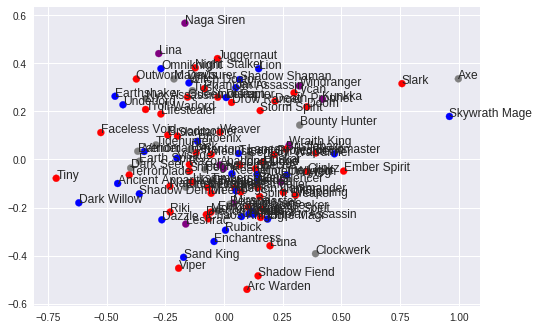

In [0]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

embedding = embedding_layer.get_weights()[0]
projection = PCA().fit_transform(embedding)
plt.scatter(projection[:, 0], projection[:, 1], c=heroes_df['color'])
for i, name in heroes_df['localized_name'].iteritems():
    plt.annotate(name, (projection[i, 0], projection[i, 1]))

We don't get a great separation of supports and carries as we hypothesized. That being said, we've made the major simplifying assumption that $W'=W^T$, our dataset is quite small, our loss is still decreasing at this point in training, and we haven't tried tuning `N_NEG`, `N_HIDDEN` or any of the other hyperparameters of the model.

This is a cool first step towards thinking about designing, gathering data for, and training embedding models for Dota 2 heroes - but there's certainly more to explore!